In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
import re
import matplotlib.pyplot as plt

# Preprocessing

In [2]:
test_df = pd.read_csv("test_dataset_without_labels.csv", encoding='utf-16-le')
test_df

,vba_code
0,"Private Sub getCIA(C As String, I As String, A..."
1,Private Sub Workbook_Open()\n Application.C...
2,'APMP\n'KILL\nPrivate Sub Document_Open()\n ...
3,Private Sub Workbook_Activate()\n Call AddM...
4,Private Sub CheckBox1_Click()\n\nEnd Sub\n\nPr...
...,...
10625,Private Sub CommandButton1_Click()\nDim s As A...
10626,Sub AutoOpen()\n\nMyMacro\n\nEnd Sub\n\nSub Do...
10627,Private Sub CommandButton1_Click()\n With A...
10628,Private Const FOSMgcqLTaUItxmhNrJ As String = ...


In [3]:
validation_df = pd.read_csv("validation_dataset.csv", encoding='utf-16-le')
validation_df

,label,vba_code
0,mal,Function SleekM()\nOn Error Resume Next\n Se...
1,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
2,white,"'Sub AutoExec() 'ð2¾(\n'ds = MsgBox(""#Wzh..."
3,white,Private Sub CommandButton1_Click()\nCall Clear...
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
...,...,...
10624,mal,Sub Auto_Open()\nApplication.EnableCancelKey =...
10625,white,"Private Sub UserForm_Initialize()\nTXTpath = ""..."
10626,white,Private Sub SpinButton1_Change()\n\nEnd Sub\n\...
10627,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...


In [4]:
train_df = pd.read_csv("train_dataset.csv", encoding='utf-16-le')
train_df

,label,vba_code
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...
1,white,Option Explicit\nOption Explicit\nOption Expli...
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...


In [5]:
np.unique(train_df.label) 

array(['mal', 'white'], dtype=object)

In [6]:
train_df.vba_code

0        Private Sub Workbook_BeforeClose(Cancel As Boo...
1        Option Explicit\nOption Explicit\nOption Expli...
2        'Option Explicit\nPrivate Sub Workbook_BeforeC...
3        'Option Explicit\nPrivate Sub Workbook_BeforeC...
4        'Option Explicit\nPrivate Sub Workbook_BeforeC...
                               ...                        
31883    'Option Explicit\nPrivate Sub Workbook_BeforeC...
31884    Option Explicit\n\nPrivate Sub Workbook_Open()...
31885    Option Explicit\n\nPrivate Sub CFixPicture_Act...
31886    'Option Explicit\nPrivate Sub Workbook_BeforeC...
31887    'Option Explicit\nPrivate Sub Workbook_BeforeC...
Name: vba_code, Length: 31888, dtype: object

In [7]:
# train_df.vba_code[2]

In [8]:
def tfidf_features(data, n_grams=2):   
    vectorizer = TfidfVectorizer(ngram_range=(n_grams, n_grams)) 
    X = vectorizer.fit_transform(data)

    print("Feature names with n-gram word: ", vectorizer.get_feature_names_out())
#     print("Vectorizer Matrix (Sparse): ")
#     print(X)

In [9]:
# not good with big data
tfidf_features(train_df.vba_code, 2)

Feature names with n-gram word:  ['00 00' '00 000' '00 0000' ... 'ÿâ cz' 'ÿån nn' 'ÿånnxýoïk kð']


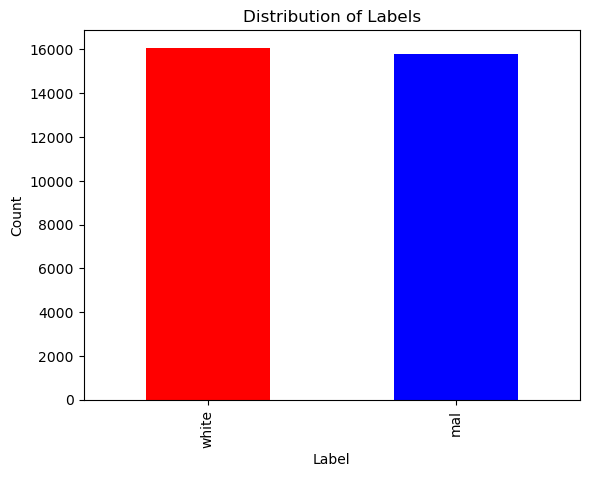

In [10]:
# Assuming 'label' is the column containing 'mal' and 'white' values
label_counts = train_df['label'].value_counts()

# Plotting the counts
label_counts.plot(kind='bar', color=['red', 'blue'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [11]:
# Assuming train_df is your DataFrame
duplicates = train_df[train_df.duplicated()]

# Check if there are any duplicates
if duplicates.shape[0] > 0:
    print("Duplicate rows found!")
    print(duplicates)
else:
    print("No duplicates found.")


Duplicate rows found!
       label                                           vba_code
3        mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
4        mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
7        mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
15       mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
18       mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
...      ...                                                ...
31882    mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
31883    mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
31884  white  Option Explicit\n\nPrivate Sub Workbook_Open()...
31886    mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
31887    mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...

[24489 rows x 2 columns]


In [12]:
# Remove all duplicate rows based on all columns
train_df.drop_duplicates(inplace=True)

# If you want to remove duplicates based on specific columns, you can use the subset parameter
# For example, to remove duplicates based on the 'vba_code' column:
train_df.drop_duplicates(subset=['vba_code'], inplace=True)
train_df

,label,vba_code
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...
1,white,Option Explicit\nOption Explicit\nOption Expli...
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
5,white,Option Explicit\n\n'Deklarationsbereich\nPriva...
6,white,Sub ýÿýÿýÿýÿýÿýÿýÿýÿ()\nAttribute ýÿýÿýÿýÿýÿýÿ...
...,...,...
31864,white,Private Function GetBase() As String\n Dim o...
31866,white,Dim satno As Integer\n\nPrivate Sub CommandBut...
31872,mal,Private Sub Workbook_Open()\nDim Rmucmw As Str...
31875,white,Option Explicit\n\nConst c_C = 264\nConst c_Ci...


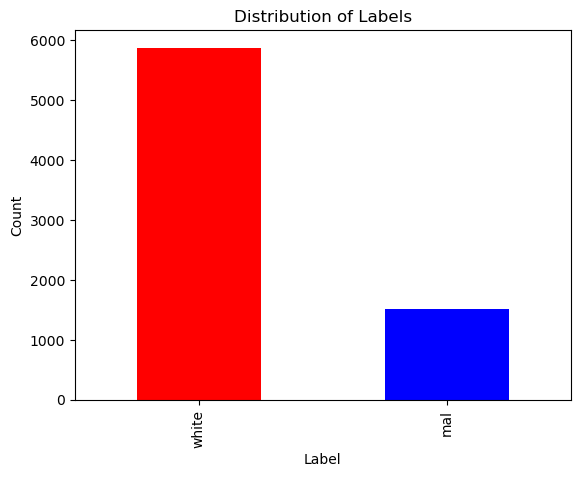

In [13]:
# Assuming 'label' is the column containing 'mal' and 'white' values
label_counts = train_df['label'].value_counts()

# Plotting the counts
label_counts.plot(kind='bar', color=['red', 'blue'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

### Extracting features

In [11]:
# Text Length
train_df['code_length'] = train_df['vba_code'].apply(len)
train_df

,label,vba_code,code_length
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...,1070
1,white,Option Explicit\nOption Explicit\nOption Expli...,13092
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428
...,...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...,12274
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...,1000
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428


In [12]:
# Number of Linens
train_df['num_lines'] = train_df['vba_code'].apply(lambda x: x.count('\n') + 1)
train_df

,label,vba_code,code_length,num_lines
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...,1070,34
1,white,Option Explicit\nOption Explicit\nOption Expli...,13092,420
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86
...,...,...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...,12274,402
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...,1000,42
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86


In [13]:
# Syntax Complexity: average number of characters per line
train_df['avg_chars_per_line'] = train_df.apply(lambda row: row['code_length'] / row['num_lines'] if row['num_lines'] > 0 else 0, axis=1)
train_df

,label,vba_code,code_length,num_lines,avg_chars_per_line
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...,1070,34,31.470588
1,white,Option Explicit\nOption Explicit\nOption Expli...,13092,420,31.171429
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465
...,...,...,...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...,12274,402,30.532338
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...,1000,42,23.809524
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465


In [14]:
# Use of Punctuation
train_df['num_exclamation_marks'] = train_df.apply(lambda row: row['vba_code'].count('!') / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
train_df

,label,vba_code,code_length,num_lines,avg_chars_per_line,num_exclamation_marks
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...,1070,34,31.470588,0.000000
1,white,Option Explicit\nOption Explicit\nOption Expli...,13092,420,31.171429,0.000229
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042
...,...,...,...,...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...,12274,402,30.532338,0.000244
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...,1000,42,23.809524,0.000000
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042


In [15]:
# Language Features
train_df['num_loops'] = train_df['vba_code'].apply(lambda x: x.count('For') + x.count('While'))
train_df

,label,vba_code,code_length,num_lines,avg_chars_per_line,num_exclamation_marks,num_loops
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...,1070,34,31.470588,0.000000,0
1,white,Option Explicit\nOption Explicit\nOption Expli...,13092,420,31.171429,0.000229,23
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1
...,...,...,...,...,...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...,12274,402,30.532338,0.000244,23
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...,1000,42,23.809524,0.000000,0
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1


In [16]:
# Loops per Character Length
train_df['num_loops_length'] = train_df.apply(lambda row: (row['vba_code'].count('For ') + row['vba_code'].count('While')) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
train_df

,label,vba_code,code_length,num_lines,avg_chars_per_line,num_exclamation_marks,num_loops,num_loops_length
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...,1070,34,31.470588,0.000000,0,0.000000
1,white,Option Explicit\nOption Explicit\nOption Expli...,13092,420,31.171429,0.000229,23,0.000687
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292
...,...,...,...,...,...,...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...,12274,402,30.532338,0.000244,23,0.000081
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...,1000,42,23.809524,0.000000,0,0.000000
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292


In [17]:
# Function/Procedure Count
train_df['num_functions'] = train_df['vba_code'].apply(lambda x: x.count('Sub ') + x.count('Function '))
train_df

,label,vba_code,code_length,num_lines,avg_chars_per_line,num_exclamation_marks,num_loops,num_loops_length,num_functions
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...,1070,34,31.470588,0.000000,0,0.000000,4
1,white,Option Explicit\nOption Explicit\nOption Expli...,13092,420,31.171429,0.000229,23,0.000687,29
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,8
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,8
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,8
...,...,...,...,...,...,...,...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,8
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...,12274,402,30.532338,0.000244,23,0.000081,41
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...,1000,42,23.809524,0.000000,0,0.000000,6
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,8


In [18]:
# Functions per Character Length:
train_df['num_functions'] = train_df.apply(lambda row: (row['vba_code'].count('Sub ') + row['vba_code'].count('Function ')) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
train_df

,label,vba_code,code_length,num_lines,avg_chars_per_line,num_exclamation_marks,num_loops,num_loops_length,num_functions
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...,1070,34,31.470588,0.000000,0,0.000000,0.003738
1,white,Option Explicit\nOption Explicit\nOption Expli...,13092,420,31.171429,0.000229,23,0.000687,0.002215
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334
...,...,...,...,...,...,...,...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...,12274,402,30.532338,0.000244,23,0.000081,0.003340
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...,1000,42,23.809524,0.000000,0,0.000000,0.006000
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334


In [19]:
# Numeric Literal Count (using regular expresion)
train_df['num_numeric_literals'] = train_df.apply(lambda row: len(re.findall(r'\b\d+\b', row['vba_code'])) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
train_df

,label,vba_code,code_length,num_lines,avg_chars_per_line,num_exclamation_marks,num_loops,num_loops_length,num_functions,num_numeric_literals
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...,1070,34,31.470588,0.000000,0,0.000000,0.003738,0.001869
1,white,Option Explicit\nOption Explicit\nOption Expli...,13092,420,31.171429,0.000229,23,0.000687,0.002215,0.008631
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253
...,...,...,...,...,...,...,...,...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...,12274,402,30.532338,0.000244,23,0.000081,0.003340,0.007414
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...,1000,42,23.809524,0.000000,0,0.000000,0.006000,0.000000
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253


In [20]:
# String Literal Count
train_df['num_string_literals'] = train_df.apply(lambda row: len(re.findall(r'"([^"]*)"', row['vba_code'])) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
train_df

,label,vba_code,code_length,num_lines,avg_chars_per_line,num_exclamation_marks,num_loops,num_loops_length,num_functions,num_numeric_literals,num_string_literals
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...,1070,34,31.470588,0.000000,0,0.000000,0.003738,0.001869,0.005607
1,white,Option Explicit\nOption Explicit\nOption Expli...,13092,420,31.171429,0.000229,23,0.000687,0.002215,0.008631,0.006416
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460
...,...,...,...,...,...,...,...,...,...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...,12274,402,30.532338,0.000244,23,0.000081,0.003340,0.007414,0.003748
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...,1000,42,23.809524,0.000000,0,0.000000,0.006000,0.000000,0.000000
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460


In [21]:
# Error Handling Presence
train_df['has_error_handling'] = train_df['vba_code'].apply(lambda x: 1 if 'On Error' in x else 0)
train_df

,label,vba_code,code_length,num_lines,avg_chars_per_line,num_exclamation_marks,num_loops,num_loops_length,num_functions,num_numeric_literals,num_string_literals,has_error_handling
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...,1070,34,31.470588,0.000000,0,0.000000,0.003738,0.001869,0.005607,0
1,white,Option Explicit\nOption Explicit\nOption Expli...,13092,420,31.171429,0.000229,23,0.000687,0.002215,0.008631,0.006416,1
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0
...,...,...,...,...,...,...,...,...,...,...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...,12274,402,30.532338,0.000244,23,0.000081,0.003340,0.007414,0.003748,1
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...,1000,42,23.809524,0.000000,0,0.000000,0.006000,0.000000,0.000000,1
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0


In [22]:
# Code Comment Density
train_df['comment_density'] = train_df.apply(lambda row: row['vba_code'].count("'") / (row['vba_code'].count('\n') + 1) if (row['vba_code'].count('\n') + 1) > 0 else 0, axis=1)
train_df

,label,vba_code,code_length,num_lines,avg_chars_per_line,num_exclamation_marks,num_loops,num_loops_length,num_functions,num_numeric_literals,num_string_literals,has_error_handling,comment_density
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...,1070,34,31.470588,0.000000,0,0.000000,0.003738,0.001869,0.005607,0,0.117647
1,white,Option Explicit\nOption Explicit\nOption Expli...,13092,420,31.171429,0.000229,23,0.000687,0.002215,0.008631,0.006416,1,0.185714
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,0.255814
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,0.255814
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,0.255814
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,0.255814
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...,12274,402,30.532338,0.000244,23,0.000081,0.003340,0.007414,0.003748,1,0.104478
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...,1000,42,23.809524,0.000000,0,0.000000,0.006000,0.000000,0.000000,1,0.095238
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,0.255814


In [ ]:
# private libraries (passwords, and personal data..)


In [ ]:
# link to other locations to open "back door"


In [ ]:
# obfuscation or not (use de-obfuscation methods if yes)


# Features selection

In [ ]:
# PCA, VarianceThreshold, SelectKBest, Tree-based feature selection

# Training (Models)

In [ ]:
# Ensemble learning

# Evaluations (using validation to check overfiting)

In [23]:
# confusion matrix, f1 score, report

# Predictions using test data